In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import GPy
plt.style.use('seaborn-whitegrid')

12288


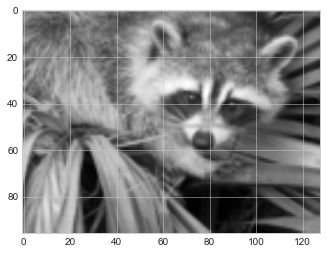

In [281]:
from scipy import misc
f = misc.face()
misc.imsave('face.png', f) # uses the Image module (PIL)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

f = rgb2gray(f)
newsize = tuple([x/8 for x in f.shape])
f = misc.imresize(f, newsize, interp='bilinear', mode=None)
print f.size

plt.imshow(f, cmap=plt.cm.gist_gray)
plt.show()

In [282]:
mask_flat = np.zeros(f.size, dtype=bool)
ind_flat = np.random.choice(f.size, int(f.size*0.5), replace=False)
mask_flat[ind_flat] = True
xv, yv = np.meshgrid(np.arange(f.shape[1]), np.arange(f.shape[0]))
Xfull = np.vstack((xv.ravel(), yv.ravel())).T
f_flat = 1*f.ravel()
f_flat[~mask_flat] = 255

In [ ]:
X = Xfull[ind_flat, :]
Y = f_flat[ind_flat][:, None]
ker = GPy.kern.RBF(2, ARD=False)
m = GPy.models.GPRegression(X, Y, ker)
m.likelihood.variance.fix(1e-6)
#m.kern.variance.fix(1e-3)
#m.kern.lengthscale.fix(1.)
m.optimize('tnc', messages=1, max_f_eval = 1000)

In [ ]:
f_rec_mean, f_rec_sigma = m.predict(Xfull, full_cov=False, include_likelihood=False)
f_rec_mean = f_rec_mean.reshape(f.shape)

In [ ]:
fac = 2
num1, num0 = fac*f.shape[1], fac*f.shape[0]
xvhigh, yvhigh = np.meshgrid(np.linspace(0, f.shape[1], num1), np.linspace(0, f.shape[0], num0))
Xhigh = np.vstack((xvhigh.ravel(), yvhigh.ravel())).T
f_high_mean, f_high_sigma = m.predict(Xhigh, full_cov=False, include_likelihood=False)
f_high_mean = f_high_mean.reshape(xvhigh.shape)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.ravel()
axs[0].set_title('Input image')
axs[0].imshow(f, cmap=plt.cm.gist_gray)
axs[1].set_title('Sparse data')
axs[1].imshow(f_obs, cmap=plt.cm.gist_gray)
axs[2].set_title('Reconstruction')
axs[2].imshow(f_rec_mean, cmap=plt.cm.gist_gray)
axs[3].set_title('High-res reconstruction')
axs[3].imshow(f_high_mean, cmap=plt.cm.gist_gray)